In [30]:
# Cell 0 — Imports + user configuration
%matplotlib inline

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os  # added (for env-based data paths)

from matplotlib import cm
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestRegressor

from spotdesirability.utils.desirability import DMin, DMax, DOverall
# If your spotdesirability has DTarget, you can enable "target" mode below
try:
    from spotdesirability.utils.desirability import DTarget
    HAS_DTARGET = True
except Exception:
    HAS_DTARGET = False

from spotoptim.mo.pareto import plot_mo, mo_pareto_optx_plot
from spotoptim.eda.plots import plot_ip_boxplots, plot_ip_histograms

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

warnings.filterwarnings("ignore")

# -----------------------------
# USER CONFIGURATION
# -----------------------------
# Use env vars or local relative paths to avoid hardcoding machine-specific locations
path_x = os.getenv("PIPE3_X_PATH", "df_x_normalized.csv")
path_z = os.getenv("PIPE3_Z_PATH", "df_z_normalized.csv")

selected_objectives = [0, 7]     # e.g., z1 and z8
selected_var_pair   = [0, 1]     # e.g., x1 and x2 (used for surface/contour slice)

n_grid = 70

# Objective direction per selected objective: "max" or "min" or "target"
objective_modes = ["max", "max"]

# Used only if objective mode is set to "target" (and DTarget is available)
objective_targets = [None, None]   # e.g., [0.8, 0.6]

# Desirability scale (steepness)
desirability_scale = 5

# Random Forest parameters
n_estimators = 100
max_depth = None
random_state = 42

# NSGA-II parameters (full-dimensional decision space)
pop_size = 200
n_gen = 80

# Optional: force plots to show x-axis from 0 to 1 (if inputs are normalized)
force_xlim_01 = True


In [31]:
# Cell 1 — Helper functions

def force_show(fig=None):
    """
    Ensure figures are rendered in environments that may suppress plotting
    (e.g., VS Code notebooks, Quarto).
    """
    try:
        if fig is not None:
            fig.canvas.draw_idle()
        plt.show()
        plt.pause(0.001)
    except Exception:
        plt.show()


def make_desirability_objects_from_samples(
    y_samples,
    objective_modes,
    scale=5,
    objective_targets=None
):
    """
    Build per-objective desirability functions and the combined overall desirability.

    objective_modes: list like ["max","max"] or ["min","max"] or ["target","max"].
    objective_targets: same length as objective_modes; used only for "target" (requires DTarget).
    """
    y_samples = np.asarray(y_samples, dtype=float)
    n_obj = y_samples.shape[1]

    if objective_targets is None:
        objective_targets = [None] * n_obj

    d_funcs = []
    for k in range(n_obj):
        low, high = float(np.min(y_samples[:, k])), float(np.max(y_samples[:, k]))
        mode = str(objective_modes[k]).lower()

        if mode == "min":
            d = DMin(low=low, high=high, scale=scale)
        elif mode == "max":
            d = DMax(low=low, high=high, scale=scale)
        elif mode == "target":
            if not HAS_DTARGET:
                raise RuntimeError("DTarget is not available in your spotdesirability version.")
            t = objective_targets[k]
            if t is None:
                raise ValueError("For objective mode='target', you must set objective_targets[k].")
            # Note: DTarget signature can vary by version; this matches the common API.
            d = DTarget(low=low, target=float(t), high=high, scale=scale)
        else:
            raise ValueError(f"Unknown objective mode: {objective_modes[k]} (use min/max/target)")

        d_funcs.append(d)

    D_overall = DOverall(*d_funcs)
    return d_funcs, D_overall


def make_overall_desirability_grid(grid_data, D_overall):
    """Compute overall desirability values on each stored grid."""
    Dmaps = {}
    for pair, data in grid_data.items():
        Ygrid = data["Ygrid"]
        n_obj, n_grid, _ = Ygrid.shape
        Yflat = np.column_stack([Ygrid[k].ravel() for k in range(n_obj)])
        Dflat = D_overall.predict(Yflat).reshape(n_grid, n_grid)
        Dmaps[pair] = Dflat
    return Dmaps


In [32]:
# Cell 2 — Plotting utilities

def plot_surface_from_grid(grid_data, target_names=("z1", "z8")):
    """Create 3D surface plots for each objective on the evaluation grid."""
    for pair, data in grid_data.items():
        i, j = pair
        Xi, Yi, Ygrid = data["Xi"], data["Yi"], data["Ygrid"]

        fig = plt.figure(figsize=(12, 5))
        for k in range(Ygrid.shape[0]):
            ax = fig.add_subplot(1, Ygrid.shape[0], k + 1, projection="3d")
            Z = Ygrid[k]
            norm = Normalize(vmin=np.nanmin(Z), vmax=np.nanmax(Z))
            facecolors = cm.viridis(norm(Z))

            ax.plot_surface(
                Xi, Yi, Z,
                facecolors=facecolors,
                rstride=1, cstride=1,
                linewidth=0,
                antialiased=True,
                shade=False
            )

            mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
            mappable.set_array(Z)
            fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.08)

            ax.set_title(target_names[k])
            ax.set_xlabel(f"x{i+1}")
            ax.set_ylabel(f"x{j+1}")

        plt.tight_layout()
        force_show(fig)


def plot_contour_from_grid(grid_data, target_names=("z1", "z8")):
    """Create 2D contour plots for each objective on the evaluation grid."""
    for pair, data in grid_data.items():
        i, j = pair
        Xi, Yi, Ygrid = data["Xi"], data["Yi"], data["Ygrid"]

        fig, axes = plt.subplots(1, Ygrid.shape[0], figsize=(12, 5))
        if Ygrid.shape[0] == 1:
            axes = [axes]

        for k, ax in enumerate(axes):
            cs = ax.contourf(Xi, Yi, Ygrid[k], levels=25)
            ax.set_title(target_names[k])
            ax.set_xlabel(f"x{i+1}")
            ax.set_ylabel(f"x{j+1}")
            fig.colorbar(cs, ax=ax)

        plt.tight_layout()
        force_show(fig)


def plot_pareto_from_y(y_samples, func_name="PROBLEM", target_names=("z1", "z8"), pareto_mode="max"):
    """Plot the Pareto front (objective space) using the observed designs only."""
    plot_mo(
        y_orig=y_samples,
        target_names=list(target_names),
        combinations=[(0, 1)],
        pareto=pareto_mode,
        pareto_front_orig=True,
        title=f"Pareto front ({pareto_mode}imization)",
        pareto_label=True
    )
    force_show()


def plot_pareto_x_in_input_space(
    X_2d,
    y_samples,
    is_minimization=True,
    var_names=("x1", "x2"),
    target_names=("z1", "z8"),
):
    import matplotlib.pyplot as plt

    # Temporarily disable plt.show() so the upstream plotting function does not finalize the figure early
    _old_show = plt.show
    plt.show = lambda *args, **kwargs: None

    try:
        # Call the original plotting function and then adjust labels on the current figure
        mo_pareto_optx_plot(X=X_2d, Y=y_samples, minimize=is_minimization)

        fig = plt.gcf()
        axes = fig.axes

        # Relabel the main subplots (usually the first two axes)
        if len(axes) >= 2:
            for ax in axes[:2]:
                ax.set_xlabel(var_names[0])
                ax.set_ylabel(var_names[1])

            axes[0].set_title(f"{target_names[0]} (Color)")
            axes[1].set_title(f"{target_names[1]} (Color)")

        # Colorbars are often added as extra axes; update their labels if present
        if len(axes) >= 4:
            axes[-2].set_ylabel(target_names[0])
            axes[-1].set_ylabel(target_names[1])

        plt.tight_layout()

    finally:
        # Restore the original show() function
        plt.show = _old_show

    # Display the updated figure
    plt.show()



def plot_individual_desirability(d_funcs, target_names=("z1", "z8")):
    """Plot each individual desirability function."""
    for k, d in enumerate(d_funcs):
        d.plot(xlabel=target_names[k], figsize=(6, 4))
    force_show()


def plot_overall_desirability_from_grid(grid_data, Dmaps):
    """Plot the overall desirability contour for each grid."""
    for pair, data in grid_data.items():
        i, j = pair
        Xi, Yi = data["Xi"], data["Yi"]
        Dgrid = Dmaps[pair]

        fig = plt.figure(figsize=(6, 5))
        cs = plt.contourf(Xi, Yi, Dgrid, levels=25)
        plt.title("Overall desirability")
        plt.xlabel(f"x{i+1}")
        plt.ylabel(f"x{j+1}")
        plt.colorbar(cs)
        plt.tight_layout()
        force_show(fig)


In [33]:
# Cell 3 — Load data

df_x = pd.read_csv(path_x)
df_z = pd.read_csv(path_z)

print("✓ Data loaded successfully")

# Optional diagnostics (disabled by default)
VERBOSE = False
if VERBOSE:
    print("  X shape:", df_x.shape)
    print("  Z shape:", df_z.shape)

    # Basic range check
    x_min = df_x.min().min()
    x_max = df_x.max().max()
    z_min = df_z.min().min()
    z_max = df_z.max().max()

    print(f"X overall min={x_min:.6f}, max={x_max:.6f}")
    print(f"Z overall min={z_min:.6f}, max={z_max:.6f}")

X_full = df_x.values.astype(float)
y_samples = df_z.iloc[:, selected_objectives].values.astype(float)

n_var = X_full.shape[1]
pair = tuple(selected_var_pair)

target_names = (f"z{selected_objectives[0]+1}", f"z{selected_objectives[1]+1}")
var_names = (f"x{selected_var_pair[0]+1}", f"x{selected_var_pair[1]+1}")

print("Selected objectives:", target_names)
print("Selected variables :", var_names)


✓ Data loaded successfully
Selected objectives: ('z1', 'z8')
Selected variables : ('x1', 'x2')


In [34]:
# Cell 4 — Evaluation metrics and helpers

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def rmse(y_true, y_pred):
    """Root mean squared error."""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def nmse(y_true, y_pred):
    """Normalized MSE (MSE divided by the variance of y_true)."""
    mse = mean_squared_error(y_true, y_pred)
    var = float(np.var(y_true))
    return float(mse / var) if var > 0 else np.nan


def nmae(y_true, y_pred):
    """Normalized MAE (MAE divided by the range of y_true)."""
    mae = mean_absolute_error(y_true, y_pred)
    y_range = float(np.max(y_true) - np.min(y_true))
    return float(mae / y_range) if y_range > 0 else np.nan


In [36]:
# Cell 5 — Hold-out evaluation

def evaluate_holdout_models(
    X, Y, target_names,
    test_size=0.30,
    random_state=42,
    n_estimators=200,
    max_depth=None,
    do_plots=True
):
    """
    Evaluate per-objective surrogate models using a train/test split.
    Optionally prints metrics and shows diagnostic plots (actual vs predicted, residuals).
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)

    Xtr, Xte, Ytr, Yte = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )

    models = []
    metrics = []

    # Optional metric printing (disabled by default)
    VERBOSE = False

    for k in range(Y.shape[1]):
        # Train RF for each objective
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
            n_jobs=-1
        )
        model.fit(Xtr, Ytr[:, k])
        pred = model.predict(Xte)

        r2 = float(r2_score(Yte[:, k], pred))
        mae = float(mean_absolute_error(Yte[:, k], pred))
        _rmse = rmse(Yte[:, k], pred)

        metrics.append((target_names[k], r2, mae, _rmse))
        models.append(model)

        if VERBOSE:
            print(f"[Holdout] {target_names[k]} | R2={r2:.4f} | MAE={mae:.4f} | RMSE={_rmse:.4f}")

        if do_plots:
            # Actual vs Predicted
            fig = plt.figure(figsize=(5.5, 5))
            plt.scatter(Yte[:, k], pred, s=18, alpha=0.7, edgecolors="none")
            mn = min(float(np.min(Yte[:, k])), float(np.min(pred)))
            mx = max(float(np.max(Yte[:, k])), float(np.max(pred)))
            plt.plot([mn, mx], [mn, mx], linewidth=2)
            plt.title(f"Actual vs Predicted — {target_names[k]}")
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Residuals vs Predicted
            resid = Yte[:, k] - pred
            fig = plt.figure(figsize=(5.5, 5))
            plt.scatter(pred, resid, s=18, alpha=0.7, edgecolors="none")
            plt.axhline(0.0, linewidth=2)
            plt.title(f"Residuals vs Predicted — {target_names[k]}")
            plt.xlabel("Predicted")
            plt.ylabel("Residual (Actual - Pred)")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

    return models, metrics


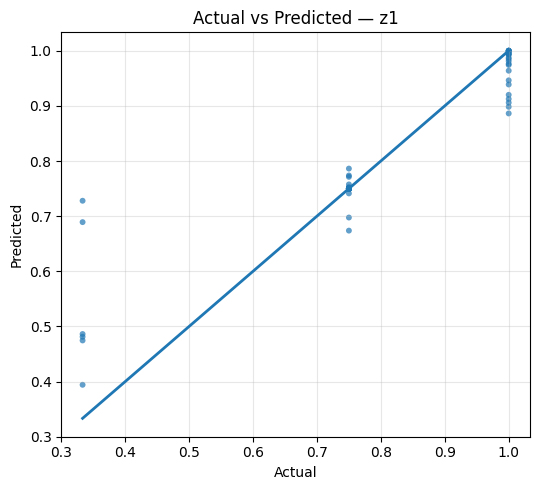

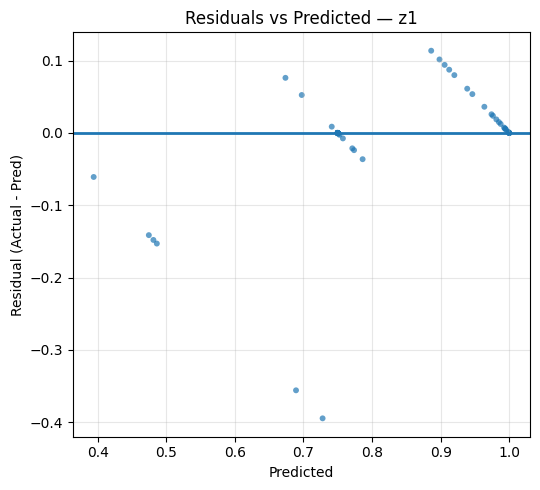

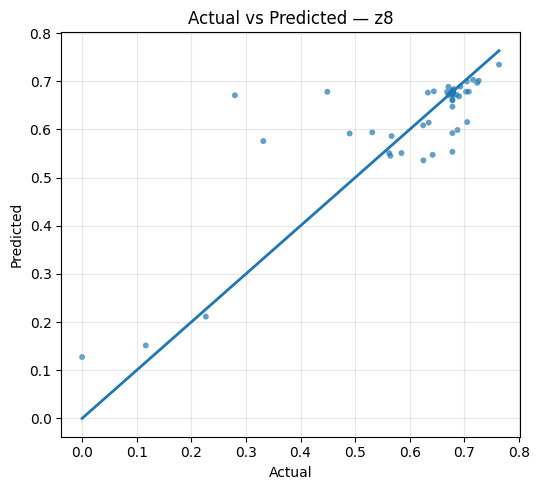

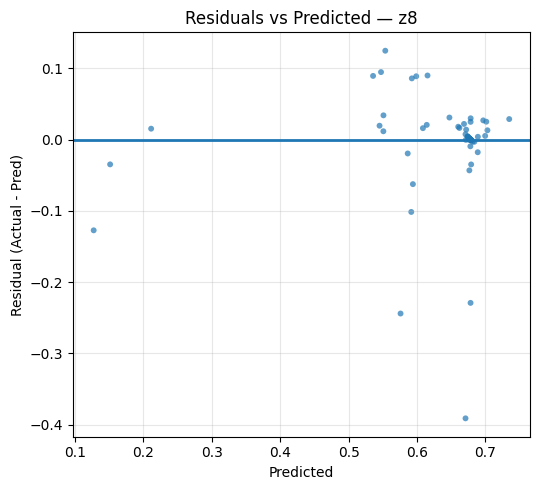

In [37]:
# Cell 6 — Execute hold-out evaluation

models_rf_holdout, holdout_metrics = evaluate_holdout_models(
    X=X_full,
    Y=y_samples,
    target_names=target_names,
    test_size=0.30,
    random_state=random_state,
    n_estimators=200,
    max_depth=max_depth,
    do_plots=True
)


In [38]:
# Cell 7 — Cross-validation comparison

def compare_models_cv(
    X, Y, target_names,
    n_splits=5,
    random_state=42,
    rf_n_estimators=200,
    rf_max_depth=None,
    do_plots=False
):
    """
    Compare Random Forest and Gaussian Process models using k-fold cross-validation
    with out-of-fold predictions. Optionally prints metrics and/or shows diagnostics.
    """
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float)

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    results = []

    # Optional metric printing (disabled by default)
    VERBOSE = False

    for k in range(Y.shape[1]):
        y = Y[:, k]

        rf = RandomForestRegressor(
            n_estimators=rf_n_estimators,
            max_depth=rf_max_depth,
            random_state=random_state,
            n_jobs=-1
        )

        # Simple GP setup (often fine for normalized targets; may be slower for larger datasets)
        kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=random_state)

        # Out-of-fold predictions
        pred_rf = cross_val_predict(rf, X, y, cv=cv, n_jobs=-1)
        pred_gp = cross_val_predict(gp, X, y, cv=cv, n_jobs=None)

        # Metrics
        for name, pred in [("RF", pred_rf), ("GP", pred_gp)]:
            r2 = float(r2_score(y, pred))
            mse = float(mean_squared_error(y, pred))
            mae = float(mean_absolute_error(y, pred))
            _nmse = nmse(y, pred)
            _nmae = nmae(y, pred)

            results.append((target_names[k], name, r2, mse, mae, _nmse, _nmae))

            if VERBOSE:
                print(f"[CV] {target_names[k]} | {name} | R2={r2:.4f} | MSE={mse:.6f} | MAE={mae:.6f} | NMSE={_nmse:.4f} | NMAE={_nmae:.4f}")

        if do_plots:
            # Optional: actual vs predicted (out-of-fold) for RF and GP
            fig = plt.figure(figsize=(6, 5))
            plt.scatter(y, pred_rf, s=14, alpha=0.6, label="RF", edgecolors="none")
            plt.scatter(y, pred_gp, s=14, alpha=0.6, label="GP", edgecolors="none")
            mn = float(np.min(y))
            mx = float(np.max(y))
            plt.plot([mn, mx], [mn, mx], linewidth=2)
            plt.title(f"CV Actual vs Predicted — {target_names[k]}")
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

    return results


cv_results = compare_models_cv(
    X=X_full,
    Y=y_samples,
    target_names=target_names,
    n_splits=5,
    random_state=random_state,
    rf_n_estimators=200,
    rf_max_depth=max_depth,
    do_plots=False
)


In [39]:
# Cell 8 — Grid preparation and surrogate models for visualization

# Fixed baseline (median per variable) used to embed the 2D slice into the full decision space
fixed_full = np.median(X_full, axis=0)

# Slice data for the selected variable pair
X_2d = X_full[:, list(pair)]
var1_min, var1_max = float(X_2d[:, 0].min()), float(X_2d[:, 0].max())
var2_min, var2_max = float(X_2d[:, 1].min()), float(X_2d[:, 1].max())
bounds = ((var1_min, var1_max), (var2_min, var2_max))

# Optional diagnostics (disabled by default)
VERBOSE = False
if VERBOSE:
    print(f"Slice bounds: {var_names[0]} [{var1_min:.4f}, {var1_max:.4f}], {var_names[1]} [{var2_min:.4f}, {var2_max:.4f}]")

def embed_2d_to_full_from_fixed_full(X_2d, fixed_full, pair=(0, 1)):
    """Embed 2D points into the full-dimensional vector using fixed_full as a baseline."""
    X_2d = np.asarray(X_2d, dtype=float)
    fixed_full = np.asarray(fixed_full, dtype=float)
    X_full_embed = np.tile(fixed_full, (X_2d.shape[0], 1))
    i, j = pair
    X_full_embed[:, i] = X_2d[:, 0]
    X_full_embed[:, j] = X_2d[:, 1]
    return X_full_embed

# Train surrogate models on the full decision space (used to predict values on the visualization grid)
if VERBOSE:
    print("\nTraining surrogate models for grid visualization (full decision space)...")
grid_models = []
for k in range(y_samples.shape[1]):
    m = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        max_depth=max_depth
    )
    m.fit(X_full, y_samples[:, k])
    grid_models.append(m)
if VERBOSE:
    print(f"✓ Trained {len(grid_models)} surrogate models")

# Build the 2D grid for the selected variables and embed it into full space
grid_data = {}
xi = np.linspace(bounds[0][0], bounds[0][1], n_grid)
yi = np.linspace(bounds[1][0], bounds[1][1], n_grid)
Xi, Yi = np.meshgrid(xi, yi)
X_grid_2d = np.column_stack([Xi.ravel(), Yi.ravel()])
X_grid_full = embed_2d_to_full_from_fixed_full(X_grid_2d, fixed_full=fixed_full, pair=pair)

Ygrid = np.zeros((2, n_grid, n_grid), dtype=float)
for k in range(2):
    Y_pred = grid_models[k].predict(X_grid_full)
    Ygrid[k] = Y_pred.reshape(n_grid, n_grid)

grid_data[pair] = {"Xi": Xi, "Yi": Yi, "Ygrid": Ygrid}
if VERBOSE:
    print("✓ Grid data created:", Ygrid.shape)

# Desirability functions computed from the observed samples
d_funcs, D_overall = make_desirability_objects_from_samples(
    y_samples=y_samples,
    objective_modes=objective_modes,
    scale=desirability_scale,
    objective_targets=objective_targets
)
Dmaps = make_overall_desirability_grid(grid_data, D_overall)
if VERBOSE:
    print("✓ Desirability objects and maps created")


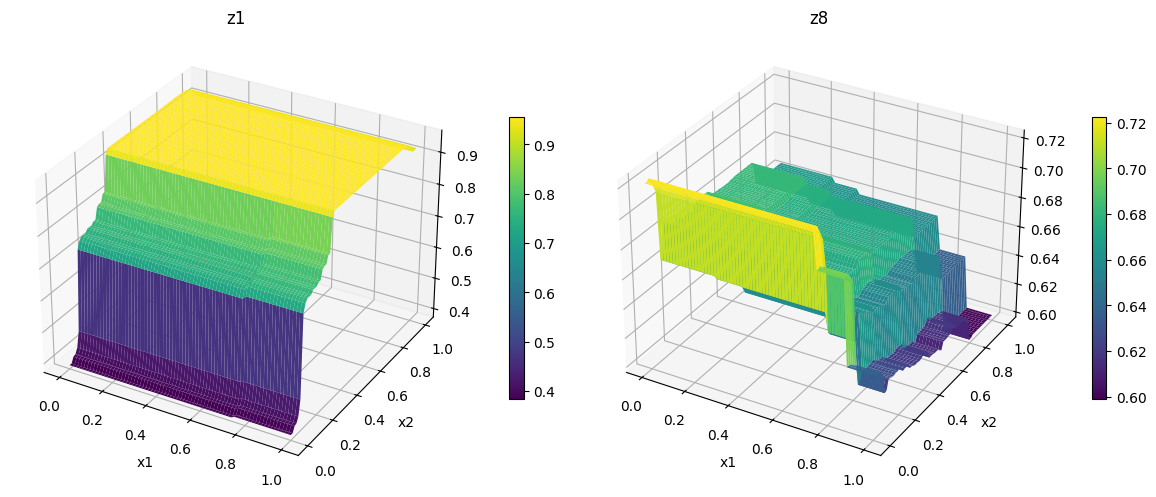

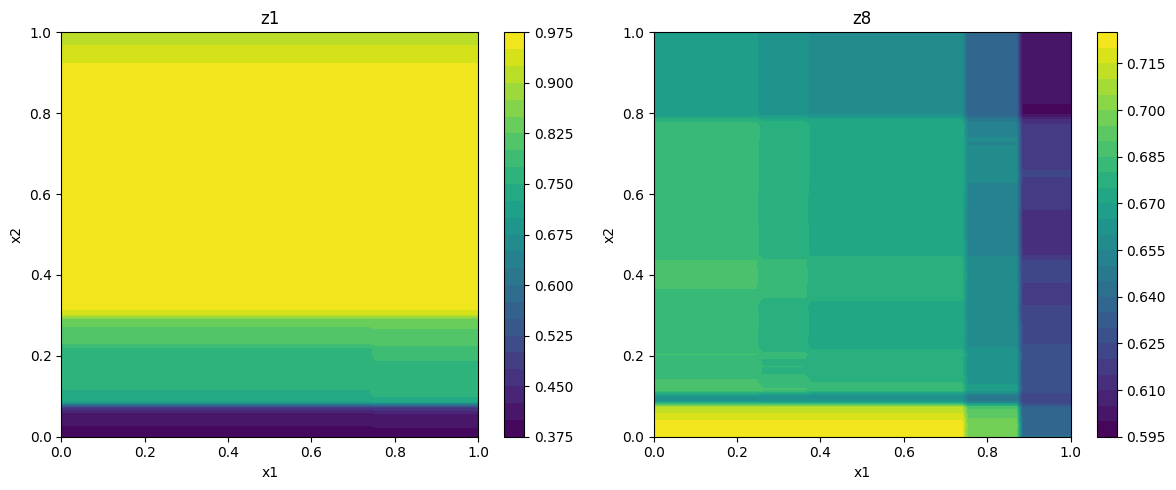

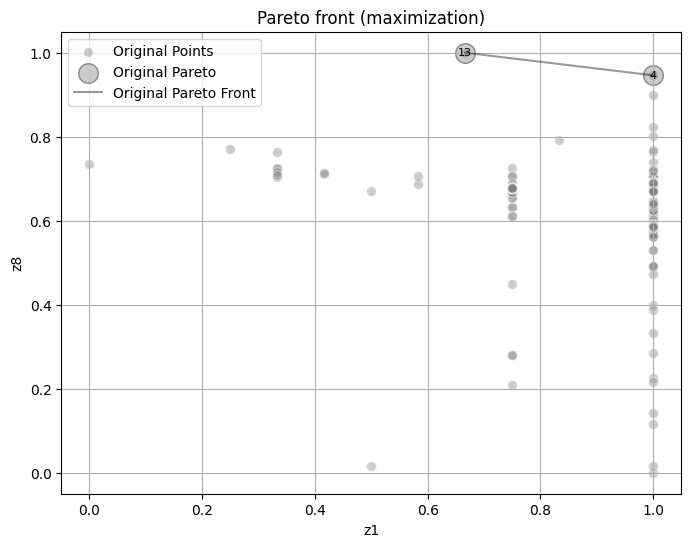

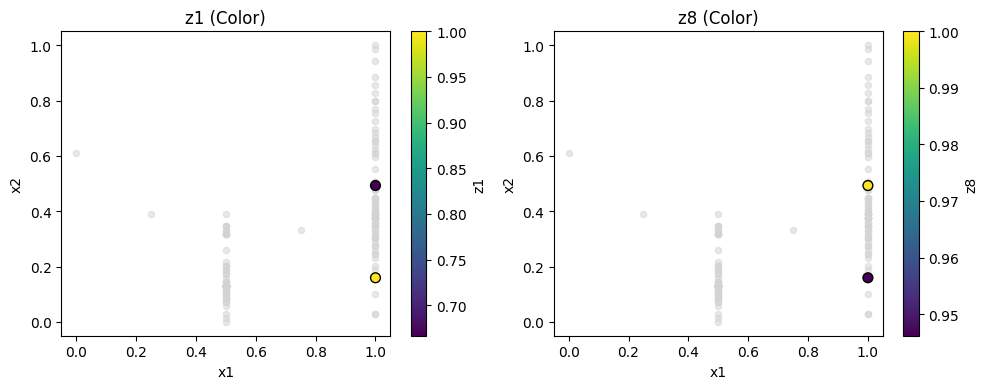

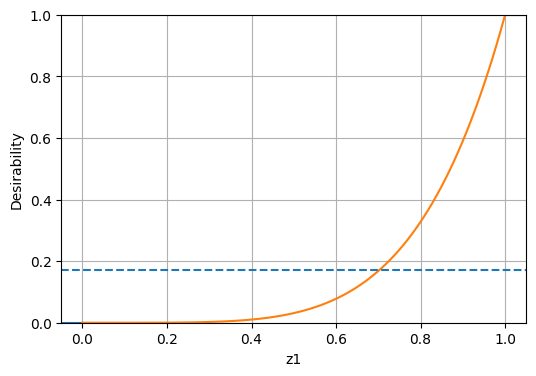

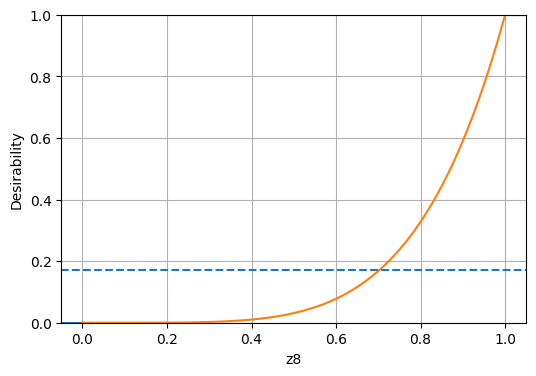

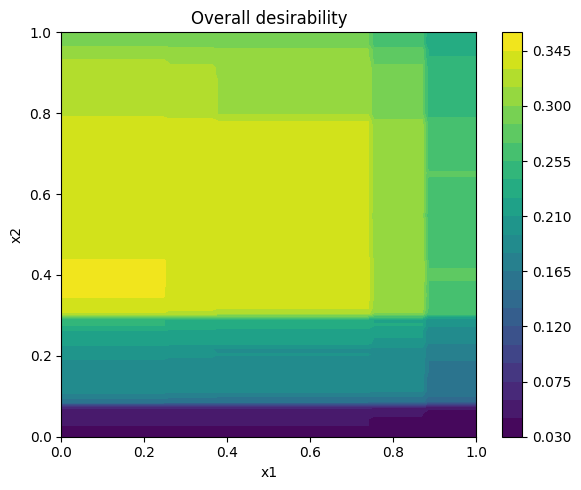

In [41]:
# Cell 9 — Generate plots

# Optional console logging (disabled by default; plots are still shown)
VERBOSE = False

if VERBOSE:
    print("\n[Plotting] Surface plots...")
plot_surface_from_grid(grid_data, target_names=target_names)

if VERBOSE:
    print("[Plotting] Contour plots...")
plot_contour_from_grid(grid_data, target_names=target_names)

# Select Pareto mode based on the objective directions
pareto_mode = "max" if all(m.lower() == "max" for m in objective_modes) else "min"

if VERBOSE:
    print("[Plotting] Pareto front (objective space) — observed designs only...")
plot_pareto_from_y(y_samples, func_name="DATASET", target_names=target_names, pareto_mode=pareto_mode)

if VERBOSE:
    print("[Plotting] Pareto-optimal points (input space) — observed designs only...")
# The minimize flag is True only when pareto_mode is 'min'
plot_pareto_x_in_input_space(
    X_2d, y_samples,
    is_minimization=(pareto_mode == "min"),
    var_names=var_names,
    target_names=target_names
)

if VERBOSE:
    print("[Plotting] Individual desirability functions...")
plot_individual_desirability(d_funcs, target_names=target_names)

if VERBOSE:
    print("[Plotting] Overall desirability (grid)...")
plot_overall_desirability_from_grid(grid_data, Dmaps)


In [42]:
# Cell 10 — Full-dimensional NSGA-II optimization

class SurrogateOptimizationProblemFull(Problem):
    """
    NSGA-II optimization in the full decision space.

    Note: Pymoo minimizes by default:
    - for "max" objectives we pass -pred so that minimizing(-pred) == maximizing(pred)
    - for "min" objectives we pass pred
    """
    def __init__(self, models, xl, xu, objective_modes):
        super().__init__(n_var=len(xl), n_obj=len(models), n_constr=0, xl=xl, xu=xu)
        self.models = models
        self.objective_modes = [m.lower() for m in objective_modes]

    def _evaluate(self, X, out, *args, **kwargs):
        F = np.zeros((X.shape[0], self.n_obj), dtype=float)
        for k in range(self.n_obj):
            pred = self.models[k].predict(X)
            if self.objective_modes[k] == "max" or self.objective_modes[k] == "target":
                F[:, k] = -pred
            else:
                F[:, k] = pred
        out["F"] = F




def optimize_full_nsga2_blue(X_full, y_samples, D_overall, objective_modes,
                             pop_size=200, n_gen=80):
    """
    Run NSGA-II on the surrogate models and select the solution with the highest
    overall desirability among the obtained non-dominated set.

    Returns:
      blue_x: selected decision vector (desirability-based)
    """
    # Train surrogate models (one model per selected objective)
    models = []
    for k in range(y_samples.shape[1]):
        m = RandomForestRegressor(
            n_estimators=n_estimators,
            random_state=random_state,
            max_depth=max_depth
        )
        m.fit(X_full, y_samples[:, k])
        models.append(m)

    # Bounds from the observed design space
    xl = np.min(X_full, axis=0).astype(float)
    xu = np.max(X_full, axis=0).astype(float)

    problem = SurrogateOptimizationProblemFull(models=models, xl=xl, xu=xu, objective_modes=objective_modes)

    algorithm = NSGA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )

    # Optional console logging (disabled by default)
    VERBOSE = False
    if VERBOSE:
        print(f"\nRunning full-dimensional NSGA-II (pop={pop_size}, gen={n_gen}) ...")

    res = minimize(problem, algorithm, ('n_gen', n_gen), seed=random_state, verbose=False)

    X_pf = res.X

    # Convert res.F back to the original objective direction for desirability evaluation
    F_minspace = res.F
    Y_pf = np.zeros_like(F_minspace, dtype=float)
    for k, mode in enumerate([m.lower() for m in objective_modes]):
        if mode == "max" or mode == "target":
            Y_pf[:, k] = -F_minspace[:, k]
        else:
            Y_pf[:, k] = F_minspace[:, k]

    # Clip predictions to the observed target range for stability
    y_low = np.min(y_samples, axis=0)
    y_high = np.max(y_samples, axis=0)
    Y_pf_clip = np.clip(Y_pf, y_low, y_high)

    Dvals = D_overall.predict(Y_pf_clip)

    # Select the point with the highest overall desirability
    blue_idx = int(np.argmax(Dvals))
    blue_x = X_pf[blue_idx]
    blue_y = Y_pf[blue_idx]
    blue_d = float(Dvals[blue_idx])

    if VERBOSE:
        print("\n=== Selected solution (desirability-based) ===")
        print("Desirability:", blue_d)
        print("Objectives:", blue_y)

    return (blue_x, blue_y, blue_d), (X_pf, Y_pf, Dvals), models


# Run the optimization and retrieve the desirability-selected solution
blue, pf_pack, models_full = optimize_full_nsga2_blue(
    X_full=X_full,
    y_samples=y_samples,
    D_overall=D_overall,
    objective_modes=objective_modes,
    pop_size=pop_size,
    n_gen=n_gen
)

blue_x, blue_y, blue_d = blue
pareto_X_full, pareto_Y, pareto_D = pf_pack


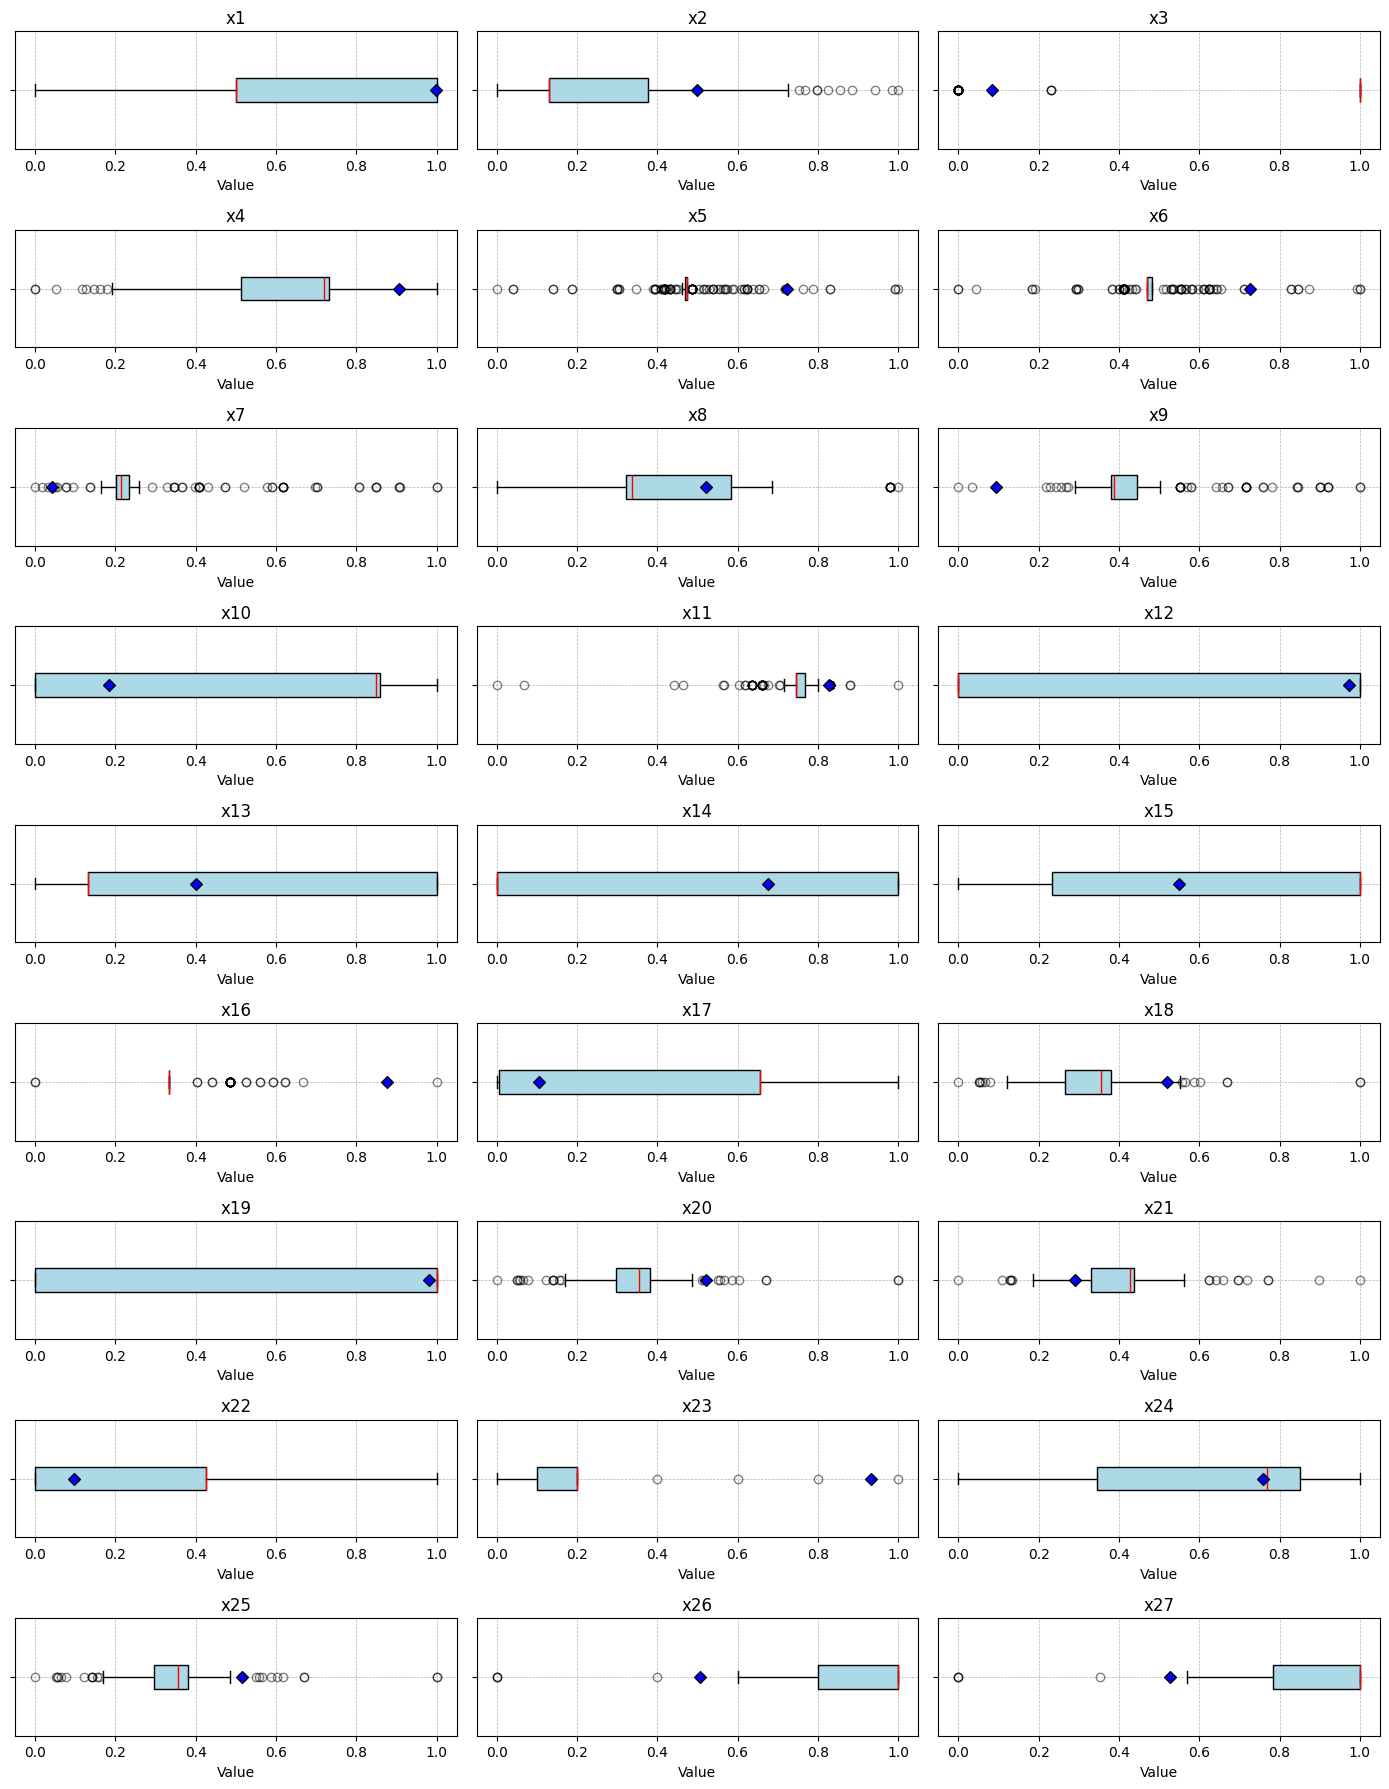

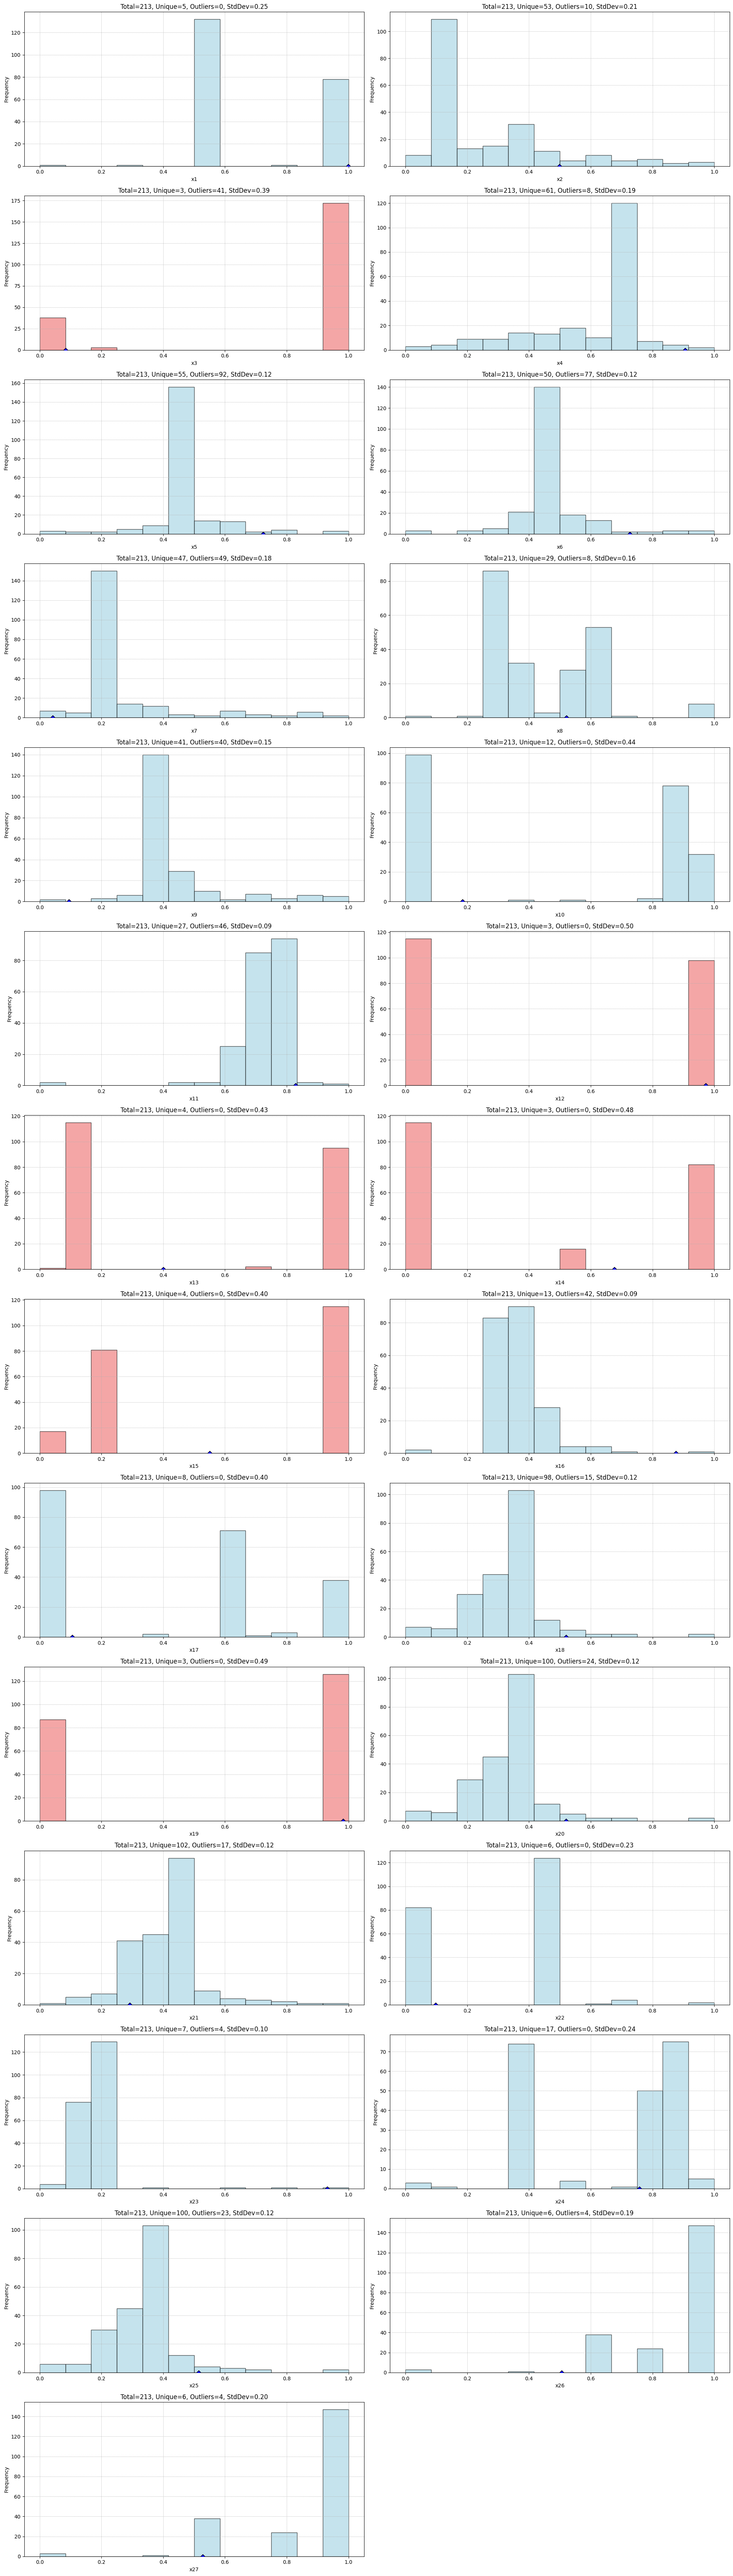

In [43]:
# Prepare DataFrame for plotting (all decision variables)
dfX = df_x.copy()

# Add the selected solution as an additional point for visualization
add_points = pd.DataFrame([blue_x], columns=dfX.columns)  # BLUE point

# Optional: clip values for visualization if inputs are normalized to [0, 1]
if force_xlim_01:
    dfX_plot = dfX.clip(0.0, 1.0)
    add_points_plot = add_points.clip(0.0, 1.0)
else:
    dfX_plot = dfX
    add_points_plot = add_points

# Optional console logging (disabled by default)
VERBOSE = False
if VERBOSE:
    print("\nPlotting ip-boxplots for all variables (blue point shown)...")
plot_ip_boxplots(
    df=dfX_plot,
    num_cols=3,
    figwidth=14,
    add_points=add_points_plot,
    add_points_col=["blue"]
)

if VERBOSE:
    print("\nPlotting ip-histograms for all variables (blue point shown)...")
plot_ip_histograms(
    df=dfX_plot,
    bins=12,
    num_cols=2,      # fewer columns -> larger subplots
    figwidth=20,     # wider figure -> improved readability
    add_points=add_points_plot,
    add_points_col=["blue"]
)
